In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import HTML

In [2]:

import numpy as np
import os
import data_utils
import pickle
import attacks
import random
from keras.models import load_model

import greedy_utils

Using TensorFlow backend.


In [3]:
TOKENIZER_PATH = 'tokenizer.pickle'
TEXT_DATA_DIR = '20_newsgroup/'
MODEL_PATH = '20news_model.h5'

In [4]:
tokenizer, inverse_tokenizer = data_utils.load_tokenizer(TOKENIZER_PATH)
model = load_model(MODEL_PATH)
labels =  list(sorted(os.listdir(TEXT_DATA_DIR)))

In [5]:
sample_file, true_label = data_utils.pick_random_file(TEXT_DATA_DIR)
file_text = data_utils.load_textfile(sample_file)
file_features = data_utils.process_text(tokenizer, file_text)

In [6]:
pred_scores = model.predict(file_features)
orig_prediction = np.argmax(pred_scores[0])
print('TrueLabel = %s' %true_label)
print('Predicted "%s" with %f .' %(labels[orig_prediction], pred_scores[0][orig_prediction]))

TrueLabel = comp.sys.mac.hardware
Predicted "comp.sys.mac.hardware" with 0.249611 .


## Greedy Attack (targeted)

Pre compute the required probabilities

In [9]:
COMPUTE_PROBS = False
if COMPUTE_PROBS:
    num_words = len(inverse_tokenizer)
    topics_words, topics_words_probs = greedy_utils.compute_topic_words(TEXT_DATA_DIR, tokenizer, 
                                                                  labels, num_words, num_cands=80000,ret_count=1000)
    with open('topic_words.pickle', 'wb') as handle:
        pickle.dump(topics_words, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('topc_words_probs.pickle', 'wb') as handle:
        pickle.dump(topics_words_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('topic_words.pickle', 'rb') as handle:
        topics_words = pickle.load(handle)
    with open('topc_words_probs.pickle', 'rb') as handle:
        topics_words_probs = pickle.load( handle)

In [11]:
embeddings_index = {}
f = open(os.path.join('./glove.6B', 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## Demonstrating topic words

In [12]:
# Top 10 words for 
for ix, label in enumerate(labels):
    print("Top 10 words for label : ", label)
    for j in range(10):
        w_idx = topics_words[ix][j]
        w = inverse_tokenizer[w_idx]
        print(w, end="")
        w_vec = embeddings_index.get(w)
        has_embedding = not (w_vec is None)
        if has_embedding:
            print("*", end=" ")
        else:
            print("", end=" ")
        #print(w + has_embedding, end=" " )
    print("\n-----")
    print("")

Top 10 words for label :  alt.atheism
snm6394 imams* karner* buphy hausmann* newnham* chade* darice g'd chimps* 
-----

Top 10 words for label :  comp.graphics
rayshade lilley* wireframe* gifconverter theseas p3d nerone* morphing* fotis* textures* 
-----

Top 10 words for label :  comp.os.ms-windows.misc
om4 34l bxom qvtnet 0em 2tg t44* ei0l '1z6ei ne1t 
-----

Top 10 words for label :  comp.sys.ibm.pc.hardware
aspi4dos st506 f300r jmarttila n5ial guyd penev* ide* 3mb* st412 
-----

Top 10 words for label :  comp.sys.mac.hardware
c650 bredell lciii nevai c610 duos* 956s iintx q700 performa* 
-----

Top 10 words for label :  comp.windows.x
icccm gxxor xdrawline xtappcontext xsizehints noll* xtwindow statbuf xterminals entry's 
-----

Top 10 words for label :  misc.forsale
uccxkvb 02106 armegedon prnt mcfarlane* wolverine* comics* hirama sega* marvel* 
-----

Top 10 words for label :  rec.autos
villager* geico* opel* altima* awd* mustangs* gibbonsa infiniti* overpass* firebird* 
-----

T

## Attack Demonstration

In [13]:
# pick a random target label
other_labels = [x for x in range(len(labels)) if x != orig_prediction]
random_target = np.random.choice(other_labels)
print('Random target = %s' %labels[random_target])
x_orig = file_features.copy()


Random target = sci.crypt


## GreedyAttack v1 (No semantic constraints)

In [14]:
greedy_attack1 = attacks.GreedyAttack(model, topics_words, topics_words_probs,
                                     embeddings_index,inverse_tokenizer, temp=1)
x_adv, o_hist, t_hist = greedy_attack1.attack(x_orig, random_target, limit=1.0, use_embedding=False)

Attack succeeded after 57 iterations.
Original class: comp.sys.mac.hardware, Attack class: sci.crypt
Number of changed words = 48 (32.88 %)


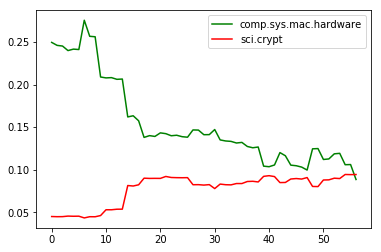

In [15]:
if x_adv is None:
    print('Attack failed. !')
else:
    adv_prediction = np.argmax(model.predict(x_adv))
    print('Attack succeeded after %d iterations.' %(len(t_hist)))
    print('Original class: %s, Attack class: %s' %(labels[orig_prediction], labels[adv_prediction]))
    print("Number of changed words = %d (%0.2f %%)"
          %(np.count_nonzero(x_adv != x_orig),
            100*(np.count_nonzero(x_adv != x_orig))/np.count_nonzero(x_orig)))
    plt.plot(o_hist, 'g', label=labels[orig_prediction])
    plt.plot(t_hist, 'r', label=labels[adv_prediction])
    plt.legend()

##### Reconstruct Text Document

In [16]:
orig_text = data_utils.reconstruct_text(inverse_tokenizer, file_features[0])
adv_text = data_utils.reconstruct_text(inverse_tokenizer, x_adv[0])

##### Visualize Attack

In [17]:
orig_html, adv_html = data_utils.render_attack(orig_text, adv_text)

In [18]:
HTML("<b> Original Text </b>")
HTML(orig_html)

In [19]:
HTML("<b> Adversarial Text </b>")
HTML(adv_html)

## GreedyAttack v2 (With semantic constraints)

In [20]:
greedy_attack2 = attacks.GreedyAttack(model, topics_words, topics_words_probs,
                                     embeddings_index,inverse_tokenizer, temp=1)
x_adv, o_hist, t_hist = greedy_attack2.attack(x_orig, random_target, limit=1.0, use_embedding=True)

Attack succeeded after 163 iterations.
Original class: comp.sys.mac.hardware, Attack class: sci.crypt
Number of changed words = 97 (66.44 %)


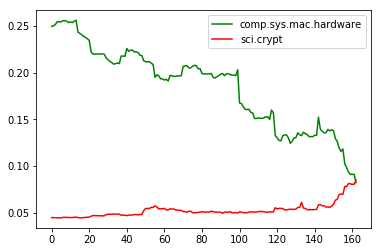

In [21]:
if x_adv is None:
    print('Attack failed. !')
else:
    adv_prediction = np.argmax(model.predict(x_adv))
    print('Attack succeeded after %d iterations.' %(len(t_hist)))
    print('Original class: %s, Attack class: %s' %(labels[orig_prediction], labels[adv_prediction]))
    print("Number of changed words = %d (%0.2f %%)"
          %(np.count_nonzero(x_adv != x_orig),
            100*(np.count_nonzero(x_adv != x_orig))/np.count_nonzero(x_orig)))
    plt.plot(o_hist, 'g', label=labels[orig_prediction])
    plt.plot(t_hist, 'r', label=labels[adv_prediction])
    plt.legend()

##### Reconstruct Text Document

In [22]:
orig_html, adv_html = data_utils.render_attack(orig_text, adv_text)

In [23]:
HTML("<b> Original Text </b>")
HTML(orig_html)

In [24]:
HTML("<b> Adversarial Text </b>")
HTML(adv_html)

## Conclusion

The greedy attack with semantic constraints will produce better looking text compared to the version 1 which doesnot have any semantic
constraints However, it will need to change more words. In this example, the v1 greedy attack changed 32% of the text
while the v2 greedy attack changed 66% of the text.

## Evaluation

In [58]:
random_files = [data_utils.pick_random_file(TEXT_DATA_DIR) for _ in range(500)]
files_, topics = zip(*random_files)

### Greedy attack evaluation

In [60]:
greedy_attack1 = attacks.GreedyAttack(model, topics_words, topics_words_probs, embeddings_index, inverse_tokenizer, 
                                     temp=1.0)
greedy_attack2 = attacks.GreedyAttack(model, topics_words, topics_words_probs, embeddings_index, inverse_tokenizer, 
                                     temp=1.0)

In [61]:
failed_cnt = 0
success_cnt = 0
failed_cnt2 = 0
success_cnt2 = 0
cnt_all = 0
dist_list = []
dist_list2 = []

attack_list = []
class_cnt = [0 for _ in range(len(labels))]
attack_matrix = np.zeros((len(labels), len(labels)))
attack_matrix2 = np.zeros((len(labels), len(labels)))

for idx in range(len(files_)):
    f_name = files_[idx]
    f_label = topics[idx]
    x_test = data_utils.load_textfile(f_name)
    x_orig = data_utils.process_text(tokenizer, x_test)
    orig_pred = np.argmax(model.predict(x_orig))
    true_label = [i for i,x in enumerate(labels) if x == f_label][0]
    if orig_pred != true_label:
        # skip
        continue
    class_cnt[true_label] += 1
    # pertrub to every other label
    other_labels = [x for x in range(len(labels)) if x != true_label]
    cnt_all += 1
    
    for t_label in other_labels:
        x_adv,_,_ = greedy_attack1.attack(x_orig, t_label)
        x_adv2, _, _ = greedy_attack2.attack(x_orig, t_label, use_embedding=True)
        if x_adv is None:
            failed_cnt += 1
        else:
            success_cnt += 1
            adv_pred = np.argmax(model.predict(x_adv))
            assert(adv_pred == t_label)
            attack_matrix[orig_pred, adv_pred] += 1
            dist_list.append(np.count_nonzero(x_adv != x_orig) / np.count_nonzero(x_orig))
        
        if x_adv2 is None:
            failed_cnt2 += 1
        else:
            adv_pred2 = np.argmax(model.predict(x_adv2))
            assert(adv_pred2 == t_label)
            dist_list2.append(np.count_nonzero(x_adv2 != x_orig) / np.count_nonzero(x_orig))


    if idx % 50 == 0:
        print(idx)


0
50
100
150
200
250
300
350
400
450


In [64]:
success_rate = 100.0 * success_cnt/ (cnt_all*19)
print('Success rate = %0.2f %%' %success_rate)

Success rate = 58.17 %


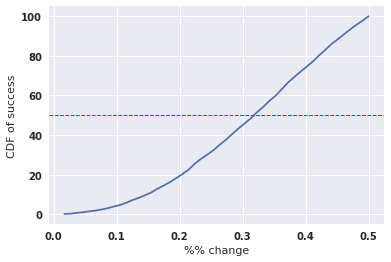

In [68]:
# Plot CDF
num_bins = 50
counts, bin_edges = np.histogram(dist_list, bins=num_bins, density=False)
cdf = np.cumsum(counts)
cdf = cdf / (success_cnt)
plt.plot(bin_edges[1:], cdf*100)
plt.axhline(y=50,linewidth=1, color='r', linestyle='--')
plt.xlabel('%% change')
plt.ylabel('CDF of success')
plt.savefig('cdf_greedy.png')

In [69]:
import seaborn as sns; sns.set()
import matplotlib

In [70]:
attack_p = attack_matrix /np.array(class_cnt).reshape((-1,1))

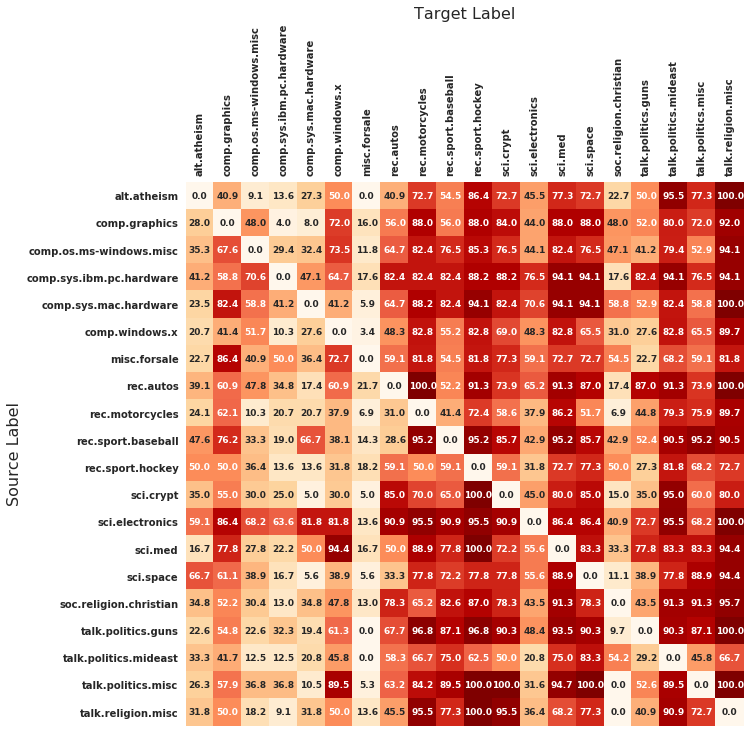

In [72]:
#sns.palplot(sns.color_palette("RdBu_r", 7)) Label
font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 9}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=((10,10)))
attack_perc = 100 * attack_p
sns.heatmap(attack_perc, annot=True, fmt="0.1f",
            yticklabels=labels, xticklabels=labels, cbar=False, cmap="OrRd"
           
           )
plt.xlabel('Target Label', fontsize=16)
plt.ylabel('Source Label', fontsize=16)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=90)
plt.savefig('greedy_heatmap.png')